# Prerequisites of Web Scraping
We have found an API that gives back (some) CC images geotagged in a 10KM radius around a set of coordinates. At what set of coordinates do we want to evaluate the API, so that the circles of 10KM radia cover the whole Europe? How do we make it so that we have to do the minimum possible API calls to cover Europe? That is a question we need to asses before doing any API call.

## Imports

In [1]:
import math
import tqdm
import folium
import shapely
import requests
import geopandas
import numpy as np
from geopy import distance
import matplotlib.pyplot as plt

## Preamble
I found out that the optimal covering of an (infinite) area using circles of radia $r$ is by arranging the circles in a honeycomb structure. That means, in rows of circles, with each row having an intendent alternatingly. Alternatively, this means that the centres of every 3 adjacent circles are form an equilateral triangle. This optimal arrangement is reached when the horizontal spacing is $r\sqrt{3}$, with an alternating intendation of $\frac{r\sqrt{3}}{2}$, and a vertical distance of $\frac{3r}{2}$. The following cell is just a sanity test.

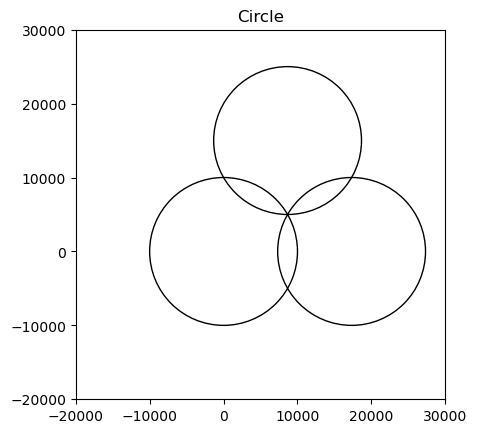

In [2]:
r = 10000
figure, axes = plt.subplots()
Drawing_uncolored_circle1 = plt.Circle( (0, 0 ),
                                      r,
                                      fill = False )
Drawing_uncolored_circle2 = plt.Circle( (math.sqrt(3)*r, 0 ),
                                      r,
                                      fill = False )
Drawing_uncolored_circle3 = plt.Circle( (math.sqrt(3)*r/2, r*3/2 ),
                                      r,
                                      fill = False )

 
axes.set_aspect(1 )
axes.add_artist(Drawing_uncolored_circle1)
axes.add_artist(Drawing_uncolored_circle2)
axes.add_artist(Drawing_uncolored_circle3)
axes.set_xlim(-2*r, 3*r)
axes.set_ylim(-2*r, 3*r)
plt.title( 'Circle' )
plt.show()

## Fetching the countries' geoshapes
Now we load the geoshapes of the European countries. The neat thing is that, given a coordinate pair, the geoshape has a method to check whether the point is within its borders. Very useful!

In [3]:
zipfile = 'NUTS_RG_01M_2021_4326.shp/NUTS_RG_01M_2021_4326.shp'
df_states = geopandas.read_file(zipfile)

In [4]:
df_states.query('LEVL_CODE == 0').head() # quick check

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,AL,0,AL,Shqipëria,Shqipëria,0.0,0,0,AL,"MULTIPOLYGON (((19.83100 42.46645, 19.83568 42..."
1,CZ,0,CZ,Česko,Česko,0.0,0,0,CZ,"POLYGON ((14.49122 51.04353, 14.49945 51.04610..."
2,DE,0,DE,Deutschland,Deutschland,0.0,0,0,DE,"MULTIPOLYGON (((10.45444 47.55580, 10.43954 47..."
3,DK,0,DK,Danmark,Danmark,0.0,0,0,DK,"MULTIPOLYGON (((15.19308 55.32014, 15.19056 55..."
4,CY,0,CY,Kýpros,Κύπρος,0.0,0,0,CY,"MULTIPOLYGON (((34.60609 35.70767, 34.60060 35..."


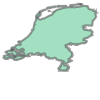

In [5]:
df_states.loc[34, 'geometry'] # how does the Netherlands look like?

### Small test
Here we check whether the ```shape.contains(point)``` method is reliable and useful for our purposes.

In [6]:
cr = df_states.loc[1, 'geometry']

x = []
y = []
mask = []
for i in tqdm.tqdm(np.arange(cr.bounds[0], cr.bounds[2], 0.01)):
    for j in np.arange(cr.bounds[1], cr.bounds[3], 0.01):
        x.append(i)
        y.append(j)
        mask.append(df_states.loc[1, 'geometry'].contains(shapely.geometry.Point(i, j)))

100%|█████████████████████████████████████████| 677/677 [01:20<00:00,  8.43it/s]


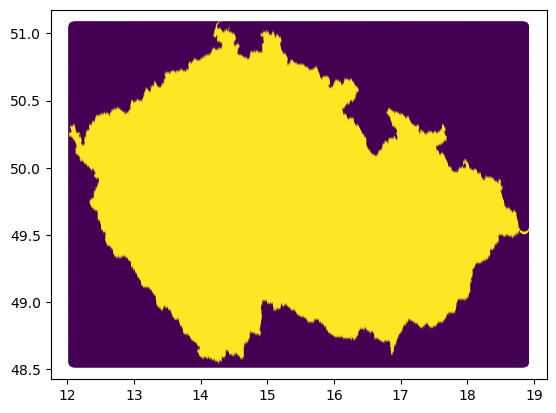

In [7]:
plt.scatter(x, y, c = mask) # we colour a point yellow if is inside the shape, purple if outside
plt.show() # that's a very accurate representation of the Czech Republic!

## Algorithms to generate the grid of points
There are two ways of doing this: either we call the API in points that are in the country, OR we call the API in points such that the 10KM radius circle and the country have a nonempty intersection. The first way is simple, the second requires a bit of thought, and a function to create a circle from a point. That is the function ```generate_circle(point)```.

In [8]:
def generate_circle(point):
    lon_centre, lat_centre = point.bounds[:2] # take the coordinates of the point
    naive_circle = point.buffer(1) # blow it to a circle. this is naive because the circle has now radius 1, but the unit of mesure here is degrees, not KM...
    lon_max, lat_max = naive_circle.bounds[2:] # take the extrema of the circle in the x and y directions
    
    lat_scaling_factor = distance.geodesic((lat_centre, lon_centre), (lat_max, lon_centre)).km # scalar s.t. the distance from centre to top of the circle is 1KM
    
    correct_lat_circle = point.buffer(10/lat_scaling_factor) # correct it. now the "circle" is an ellipsis on the degree space 
    
    lon_scaling_factor = distance.geodesic((lat_centre, lon_centre), (lat_centre, lon_max)).km # scalar s.t. the distance from centre to side of ellipsis is 1KM

    correct_circle = shapely.affinity.scale(correct_lat_circle, 111.25/lon_scaling_factor, 1) # why 111.25? lmao. found it by trial and error. valid for Netherlands
    return correct_circle

The following procedure generates the grid of points where we should call the API. How it works: it begins at the southernmost, westmost point of the box that encloses the country. Then takes 10KM steps towards the east. At each step evaluates if the point is in the country (alternatively, if its corresponding circle intersects the country). When the procedure steps too far away into the east, out of the box that contains the country, then it returns to the westernmost point, but 10KM to the north of it. Then begins the walk eastwards again. This is repeated until the procedure oversteps the northernmost, eastmost corner of the box.

In [9]:
use_circles = True
shape = df_states.loc[34, 'geometry']
lon, lat = shape.bounds[:2]
lons, lats, mask = [], [], []
radius = 10000
indent = True
while lat < shape.bounds[3]:
    while lon < shape.bounds[2]:
        point = shapely.geometry.Point(lon, lat)
        lats.append(lat); lons.append(lon)
        if use_circles:
            mask.append(shape.intersects(generate_circle(point)))
        else:
            mask.append(shape.contains(point))
        
        lat, lon, _ = distance.geodesic(meters = radius*3**0.5).destination((lat, lon), bearing = 90)
    
    lon = shape.bounds[0]
    if indent:
        lat, lon, _ = distance.geodesic(meters = 0.5*radius*3**0.5).destination((lat, lon), bearing = 90)
    lat, lon, _ = distance.distance(meters = 3*radius/2).destination((lat, lon), bearing = 0)
    
    indent = not indent

In [10]:
print('Number of points needed to scrape the Netherlands: ', np.array(mask).sum())

Number of points needed to scrape the Netherlands:  208


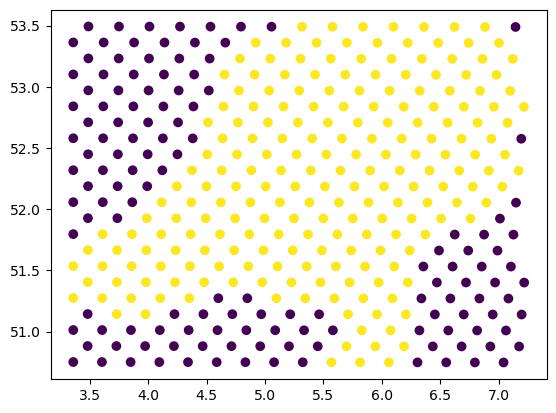

In [11]:
plt.scatter(lons, lats, c = mask) # see how it looks! same idea as before
plt.show() # we do not need that many points!

In [12]:
for lat, lon in zip(lats, lons):
    point = shapely.geometry.Point(lon, lat)
    print(
        distance.geodesic(
        (point.bounds[1], point.bounds[0]),
        (generate_circle(point).bounds[1], point.bounds[0])).km,

        distance.geodesic(
        (point.bounds[1], point.bounds[0]),
        (point.bounds[1], generate_circle(point).bounds[0])).km
    )

9.99906246063526 9.999798439847886
9.99906245884688 9.999798882945479
9.99906245705924 9.999799326040122
9.999062455271275 9.999799769131487
9.999062453481212 9.999800212219505
9.999062451694362 9.999800655304723
9.999062449906127 9.999801098386424
9.999062448117213 9.999801541465107
9.999062446329033 9.999801984540689
9.999062444541234 9.99980242761316
9.999062442753466 9.999802870682313
9.999062440965723 9.999803313748446
9.999062439176951 9.999803756811358
9.999062437390327 9.999804199871095
9.999062435602314 9.999804642927582
9.999062433816453 9.999805085981238
9.999063375309936 9.99957439445357
9.999063373473335 9.999574839147929
9.999063371637126 9.999575283839038
9.99906336980201 9.999575728527018
9.999063367967281 9.999576173211928
9.999063366131168 9.999576617893489
9.999063364295084 9.99957706257189
9.999063362460806 9.999577507247283
9.999063360625142 9.999577951919365
9.999063358791277 9.999578396588356
9.999063356955679 9.999578841254316
9.999063355120466 9.999579285916786

## Quick visualization
Notice that this plot is just an approximation: the radia of the circles is just 26-pixels long. If you zoom in or out, their size changes. So this map oly checks that the distances between points are moreless accurate.

In [13]:
ne_map = folium.Map([shape.centroid.bounds[1], shape.centroid.bounds[0], ], zoom_start=8)
for lat, lon, is_in in zip(lats, lons, mask):
    if is_in:
        folium.vector_layers.CircleMarker(
            location=[lat, lon],
            radius=26,
            color='#3186cc',
            fill=False    
        ).add_to(ne_map)

ne_map # ATTENTION: circle radia are approximated

In [87]:
radius
for lat, lon, isinshape in zip(lats, lons, mask):
    if isinshape:
        query_string = f'https://wikimap.toolforge.org/api.php?wp=false&cluster=false&dist={radius}&lat={lat}&lon={lon}&commons&allco=true&project=wikidata'
        break

response = requests.get(query_string)

In [91]:
len(response.json())

985

In [92]:
[x['ns'] for x in response.json() if x['ns'] not in (0, 6)]

[]